In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Введение

In [94]:
file_path = "data (2).xlsx"
read_df = pd.read_excel(file_path)
df = read_df[1:].T[4:60].rename(columns = {1:"Year" ,2:"USA", 3:"France"}).reset_index(drop=True)
for col in df:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Исходные данные

тут насрать текста 

# Основные компоненты временного ряда

## 3.1

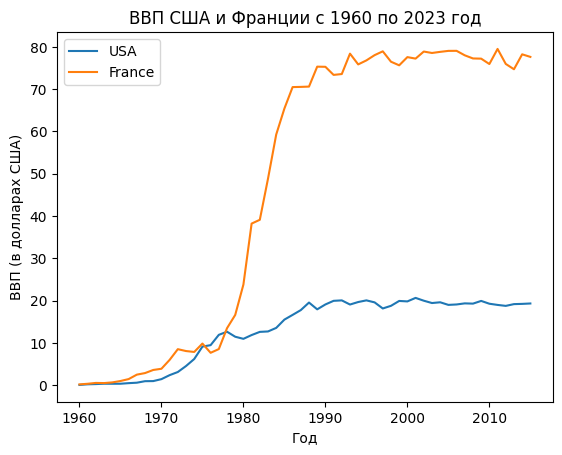

In [95]:
df.plot(x='Year', y=['USA', 'France'], kind='line')
plt.title('ВВП США и Франции с 1960 по 2023 год')
plt.ylabel('ВВП (в долларах США)')
plt.xlabel('Год')
plt.show()


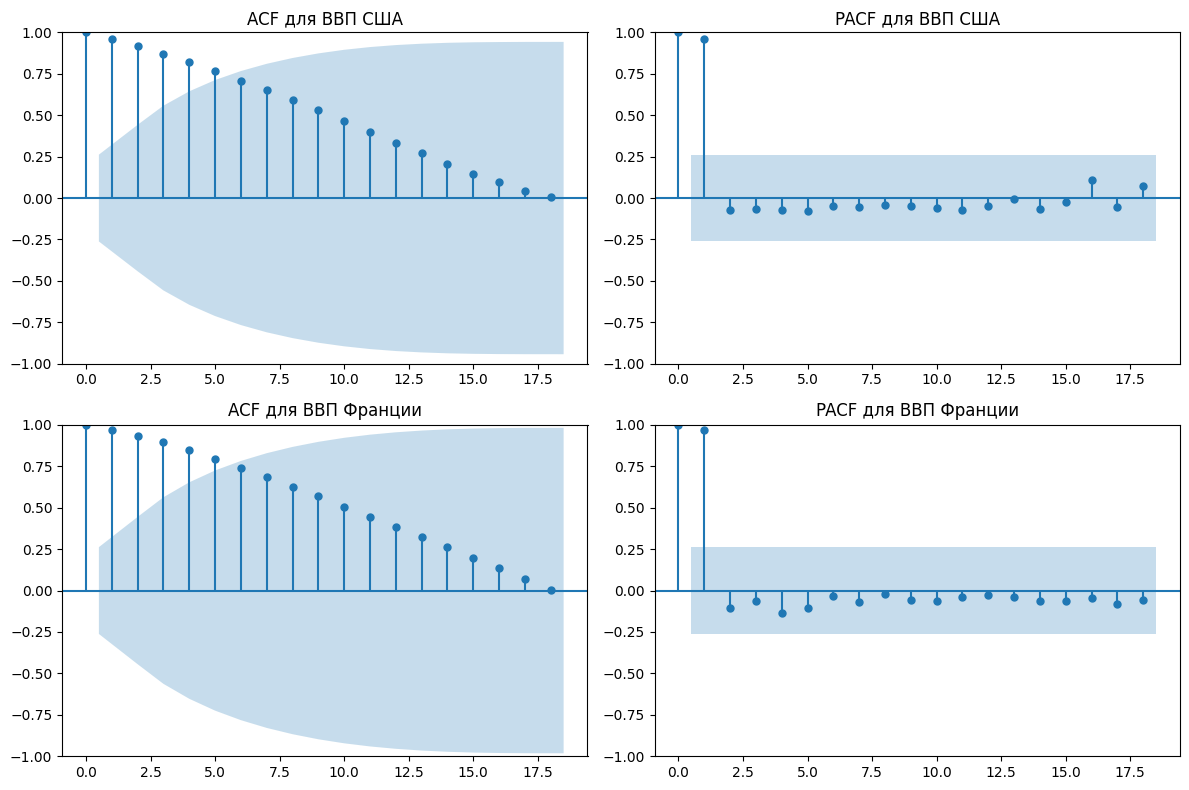

In [103]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF для США
plot_acf(df['USA'].values.squeeze(), ax=axes[0, 0], title='ACF для ВВП США')

# PACF для США
plot_pacf(df['USA'].values.squeeze(), ax=axes[0, 1], title='PACF для ВВП США')

# ACF для Франции
plot_acf(df['France'], ax=axes[1, 0], title='ACF для ВВП Франции')

# PACF для Франции
plot_pacf(df['France'], ax=axes[1, 1], title='PACF для ВВП Франции')

# Настройка расположения графиков
plt.tight_layout()
plt.show()



## 3.2

In [104]:
from statsmodels.tsa.stattools import kpss

# Для США
kpss_test_usa = kpss(df['USA'])
print('KPSS Statistic: %f' % kpss_test_usa[0])
print('p-value: %f' % kpss_test_usa[1])
print('Critical Values:')
for key, value in kpss_test_usa[3].items():
    print('\t%s: %.3f' % (key, value))

# Для Франции
kpss_test_france = kpss(df['France'])
print('KPSS Statistic: %f' % kpss_test_france[0])
print('p-value: %f' % kpss_test_france[1])
print('Critical Values:')
for key, value in kpss_test_france[3].items():
    print('\t%s: %.3f' % (key, value))


KPSS Statistic: 1.059654
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
KPSS Statistic: 1.072875
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/var/folders/rx/7jdln1v12dqfpp7h7t6hvf0s3my5pf/T/ipykernel_45109/4041580573.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_usa = kpss(df['USA'])
/var/folders/rx/7jdln1v12dqfpp7h7t6hvf0s3my5pf/T/ipykernel_45109/4041580573.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_france = kpss(df['France'])


тут насрать текста

## 3.3

In [107]:
y = df['USA']  # Временной ряд ВВП США
n = len(y)
X = np.column_stack([np.ones(n), np.arange(1, n+1)])
beta = np.linalg.inv(X.T @ X) @ X.T @ y
y_fit = X @ beta
residuals = y - y_fit
cumulative_sum = np.cumsum(residuals - np.mean(residuals))

y_france = df['France']  # Временной ряд ВВП Франции
n_france = len(y_france)
X_france = np.column_stack([np.ones(n_france), df['Year']])
beta_france = np.linalg.inv(X_france.T @ X_france) @ X_france.T @ y_france
y_france_fit = X_france @ beta_france
residuals_france = y_france - y_france_fit

cumulative_sum_france = np.cumsum(residuals_france - np.mean(residuals_france))

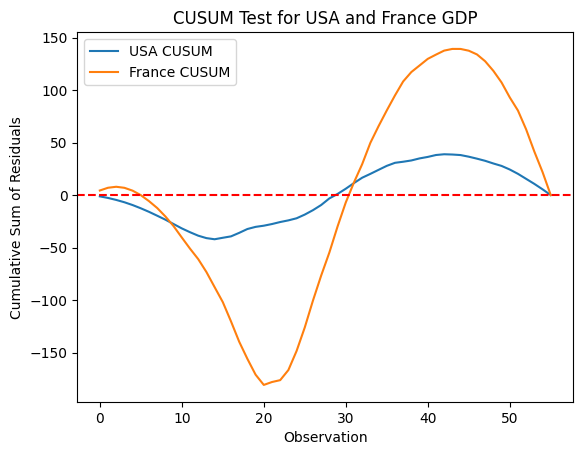

In [108]:
# График ВВП США
plt.plot(cumulative_sum, label='USA CUSUM')

# График ВВП Франции
plt.plot(cumulative_sum_france, label='France CUSUM')

# Добавляем горизонтальную линию на уровне 0 для ориентира
plt.axhline(y=0, color='r', linestyle='--')

# Настраиваем график
plt.title('CUSUM Test for USA and France GDP')
plt.xlabel('Observation')
plt.ylabel('Cumulative Sum of Residuals')
plt.legend()

# Отображаем график
plt.show()


In [109]:
import statsmodels.api as sm
from scipy.stats import f

# Определяем точку разрыва, например, 2008 год
breakpoint = 2008

# Отделяем данные для США до и после кризиса
usa_pre = df[df['Year'] < breakpoint]['USA']
usa_post = df[df['Year'] >= breakpoint]['USA']
years_pre = df[df['Year'] < breakpoint]['Year']
years_post = df[df['Year'] >= breakpoint]['Year']

# Регрессия для всего периода
X_full = sm.add_constant(df['Year'])
y_full = df['USA']
model_full = sm.OLS(y_full, X_full).fit()

# Регрессия для периода до кризиса
X_pre = sm.add_constant(years_pre)
y_pre = usa_pre
model_pre = sm.OLS(y_pre, X_pre).fit()

# Регрессия для периода после кризиса
X_post = sm.add_constant(years_post)
y_post = usa_post
model_post = sm.OLS(y_post, X_post).fit()

# Вычисляем сумму квадратов ошибок для каждой модели
ssr_full = model_full.ssr
ssr_pre = model_pre.ssr
ssr_post = model_post.ssr

# Вычисляем F-статистику для теста Чоу
n = len(y_full)  # Общее количество наблюдений
k = 2  # Количество независимых переменных (включая константу)
F = ((ssr_full - (ssr_pre + ssr_post)) / k) / ((ssr_pre + ssr_post) / (n - 2*k))

# Получаем p-value
p_value = 1 - f.cdf(F, k, n - 2*k)
print("USA F-statistic:", F)
print("USA p-value:", p_value)

# Теперь можно повторить те же шаги для данных по Франции
france_pre = df[df['Year'] < breakpoint]['France']
france_post = df[df['Year'] >= breakpoint]['France']

y_full = df['France']
model_full = sm.OLS(y_full, X_full).fit()
y_pre = france_pre
model_pre = sm.OLS(y_pre, X_pre).fit()
y_post = france_post
model_post = sm.OLS(y_post, X_post).fit()

ssr_full = model_full.ssr
ssr_pre = model_pre.ssr
ssr_post = model_post.ssr
F = ((ssr_full - (ssr_pre + ssr_post)) / k) / ((ssr_pre + ssr_post) / (n - 2*k))
p_value = 1 - f.cdf(F, k, n - 2*k)
print("France F-statistic:", F)
print("France p-value:", p_value)


USA F-statistic: 20.521476474465743
USA p-value: 2.693495878558494e-07
France F-statistic: 15.451358037137464
France p-value: 5.411269885402525e-06
